# Clasificación con Máquina de Vectores de Soporte y Redes de Neuronas

## Importamos las librerías necesarias

In [2]:
# Calculo y manipulación de datos
import pandas as pd
import numpy as np
from numpy.lib.function_base import average

# Modelizacion
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV
from sklearn import svm
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras import models
from keras import layers

# Utilidades
import os

# Visualizacion
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

# Descargar dataset
!rm /content/datasets_train.csv
!wget https://raw.githubusercontent.com/carseven/master-ai/main/machineLearning/lab2/datasets_train.csv

# Referencias
# https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/
# https://stackabuse.com/deep-learning-in-keras-data-preprocessing/
# https://www.kaggle.com/sanchit2843/neuralnetworkkeras
# https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/

# Pandas muestre todas las columnas
pd.set_option("display.max_rows", 30, "display.max_columns", None)
pylab.rcParams['figure.figsize'] = (16.0, 7.0)

rm: cannot remove '/content/datasets_train.csv': No such file or directory
--2021-02-11 21:35:56--  https://raw.githubusercontent.com/carseven/master-ai/main/machineLearning/lab2/datasets_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 122402 (120K) [text/plain]
Saving to: ‘datasets_train.csv’

datasets_train.csv  100%[===================>] 119.53K  --.-KB/s    in 0.03s   

2021-02-11 21:35:56 (4.66 MB/s) - ‘datasets_train.csv’ saved [122402/122402]



## Cargar dataset

In [3]:
data = pd.read_csv('/content/datasets_train.csv')

## Análisis descriptivo de los datos

### Analisis inicial y distinción de los tipos de variables

In [4]:
data.head(5)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

El dataset se compone de 21 variables:
 
* battery_power: Total energy a battery can store in one time measured in mAh
* blue: Has bluetooth or not
* clock_speed: speed at which microprocessor executes instructions
* dual_sim: Has dual sim support or not
* fc: front camera mega pixeles
* four_g: has 4g or not
* int_memory: Internal Memory in Gigabytes
* m_dep: Mobile Depth in cm
* mobile_wt: Weight of mobile phone
* n_cores: Number of cores of processor
* pc: Primary Camera mega pixels
* px_height: Pixel Resolution Height
* px_width: Pixel Resolution Width
* ram: Random Access Memory in Megabytes
* sc_h: Screen Height of mobile in cm
* sc_w: Screen Width of mobile in cm
* talk_time: longest time that a single battery charge will last when you are
* three_g: Has 3G or not
* touch_screen: Has touch screen or not
* wifi: Has wifi or not
* Columnas a predecir en la clasificacion.
* price_range: This is the target variable with value of 0(low cost), 1(medium cost), 2(high cost) and 3(very high cost).


Con esto hemos separado las variable categoricas de las númericas.



In [6]:
cat_columns = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen',
               'wifi', 'price_range']

num_columns = list(set(data.columns) - set(cat_columns))

print('Variables númericas:')
print(num_columns)
print('\n')
print('Variables categoricas:')
print(cat_columns)

Variables númericas:
['pc', 'px_width', 'sc_h', 'n_cores', 'clock_speed', 'mobile_wt', 'sc_w', 'battery_power', 'int_memory', 'talk_time', 'px_height', 'ram', 'm_dep', 'fc']


Variables categoricas:
['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi', 'price_range']


### Datos estadísticos de las variables númericas

In [7]:
print('Datos estadíticos de las variables númericas:')
for column in num_columns:
    cuartiles = data[column].quantile([.25, .50, .75])

    print('Variable ' + column + ':')
    print('MAX:', data[column].max())
    print('MIN:', data[column].min())
    print('MEDIA:', data[column].mean())
    print('MEDIANA:', data[column].median())
    print('25%:', cuartiles.iloc[0])
    print('50%:', cuartiles.iloc[1])
    print('75%:', cuartiles.iloc[2])
    print('\n')

Datos estadíticos de las variables númericas:
Variable pc:
MAX: 20
MIN: 0
MEDIA: 9.9165
MEDIANA: 10.0
25%: 5.0
50%: 10.0
75%: 15.0


Variable px_width:
MAX: 1998
MIN: 500
MEDIA: 1251.5155
MEDIANA: 1247.0
25%: 874.75
50%: 1247.0
75%: 1633.0


Variable sc_h:
MAX: 19
MIN: 5
MEDIA: 12.3065
MEDIANA: 12.0
25%: 9.0
50%: 12.0
75%: 16.0


Variable n_cores:
MAX: 8
MIN: 1
MEDIA: 4.5205
MEDIANA: 4.0
25%: 3.0
50%: 4.0
75%: 7.0


Variable clock_speed:
MAX: 3.0
MIN: 0.5
MEDIA: 1.5222499999999983
MEDIANA: 1.5
25%: 0.7
50%: 1.5
75%: 2.2


Variable mobile_wt:
MAX: 200
MIN: 80
MEDIA: 140.249
MEDIANA: 141.0
25%: 109.0
50%: 141.0
75%: 170.0


Variable sc_w:
MAX: 18
MIN: 0
MEDIA: 5.767
MEDIANA: 5.0
25%: 2.0
50%: 5.0
75%: 9.0


Variable battery_power:
MAX: 1998
MIN: 501
MEDIA: 1238.5185
MEDIANA: 1226.0
25%: 851.75
50%: 1226.0
75%: 1615.25


Variable int_memory:
MAX: 64
MIN: 2
MEDIA: 32.0465
MEDIANA: 32.0
25%: 16.0
50%: 32.0
75%: 48.0


Variable talk_time:
MAX: 20
MIN: 2
MEDIA: 11.011
MEDIANA: 11.0
25%: 6.0
5

### Frecuencia de las variables categoricas

In [8]:
for column in cat_columns:
    print(f'Variable {column}:')
    print(f'Listado categorias: \n{data[column].unique()}')
    print(f'Frecuencia categorias: \n{data[column].value_counts()}')
    print('\n')

Variable blue:
Listado categorias: 
[0 1]
Frecuencia categorias: 
0    1010
1     990
Name: blue, dtype: int64


Variable dual_sim:
Listado categorias: 
[0 1]
Frecuencia categorias: 
1    1019
0     981
Name: dual_sim, dtype: int64


Variable four_g:
Listado categorias: 
[0 1]
Frecuencia categorias: 
1    1043
0     957
Name: four_g, dtype: int64


Variable three_g:
Listado categorias: 
[0 1]
Frecuencia categorias: 
1    1523
0     477
Name: three_g, dtype: int64


Variable touch_screen:
Listado categorias: 
[0 1]
Frecuencia categorias: 
1    1006
0     994
Name: touch_screen, dtype: int64


Variable wifi:
Listado categorias: 
[1 0]
Frecuencia categorias: 
1    1014
0     986
Name: wifi, dtype: int64


Variable price_range:
Listado categorias: 
[1 2 3 0]
Frecuencia categorias: 
3    500
2    500
1    500
0    500
Name: price_range, dtype: int64




### Distribución de las variables númericas

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

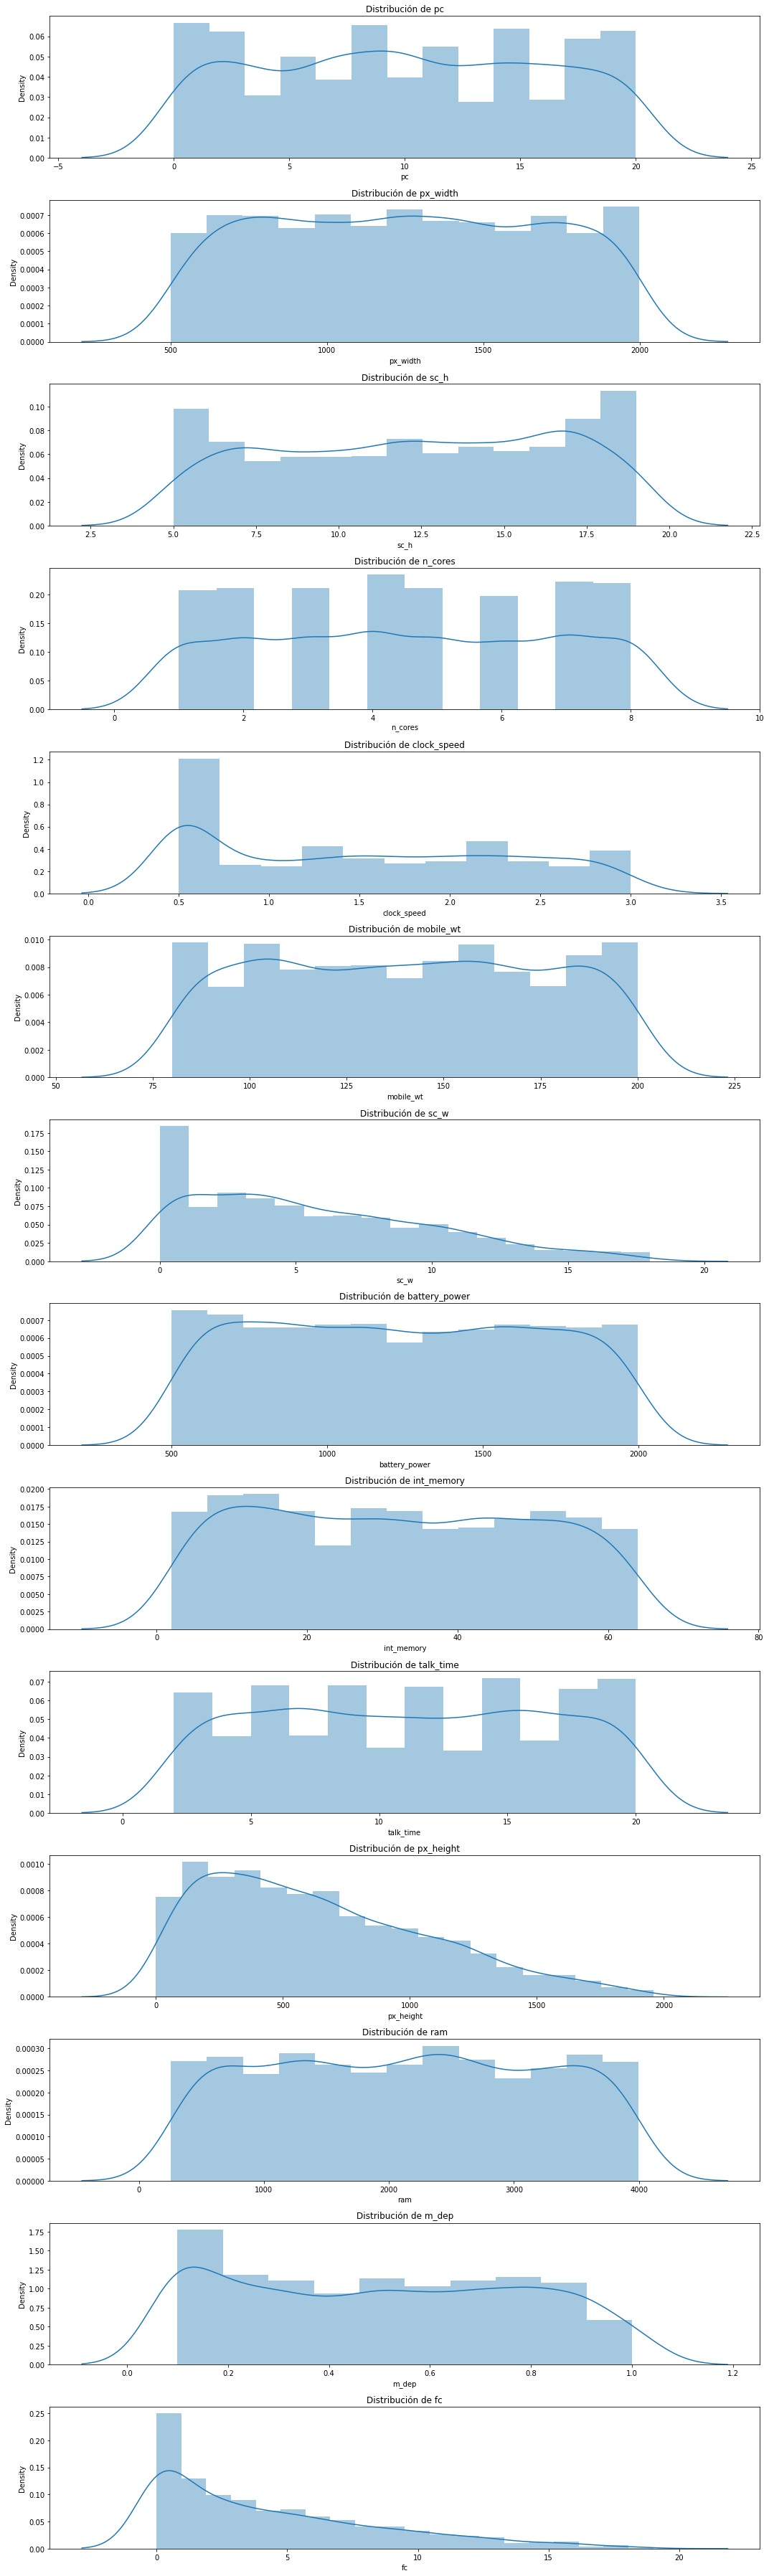

In [9]:
fig, axs = plt.subplots(len(num_columns), 1, figsize=(15, 50))

count = 0
for column in num_columns:
    fp = sb.distplot(data[column], ax=axs[count])
    fp.set_title(f'Distribución de {column}')
    count += 1

plt.tight_layout();

Se observa en algunas variables como **px_height**, **fc**, **sc_w**, una distribución no uniforme, concentrada a la izquierda (valores inferiores de la variable). 

Por norma general, cuanto mayor es el valor de la varible mayores prestaciones presenta el telefono movil y por tanto, se clasificará en un gama más alta. Se puede pensar que se tiene un desbalanceamiento en el número de muestras de las clases en estás variables. Donde la mayoría de las muestras correponde con las clases de menor precio.

Como dato curioso la variable n_cores contiene rangos donde sin ningúna muestra. Esto se puede deber a normalmente el número de núcleo en un procesador suele ser par.

### Distribución de las variables categoricas

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn

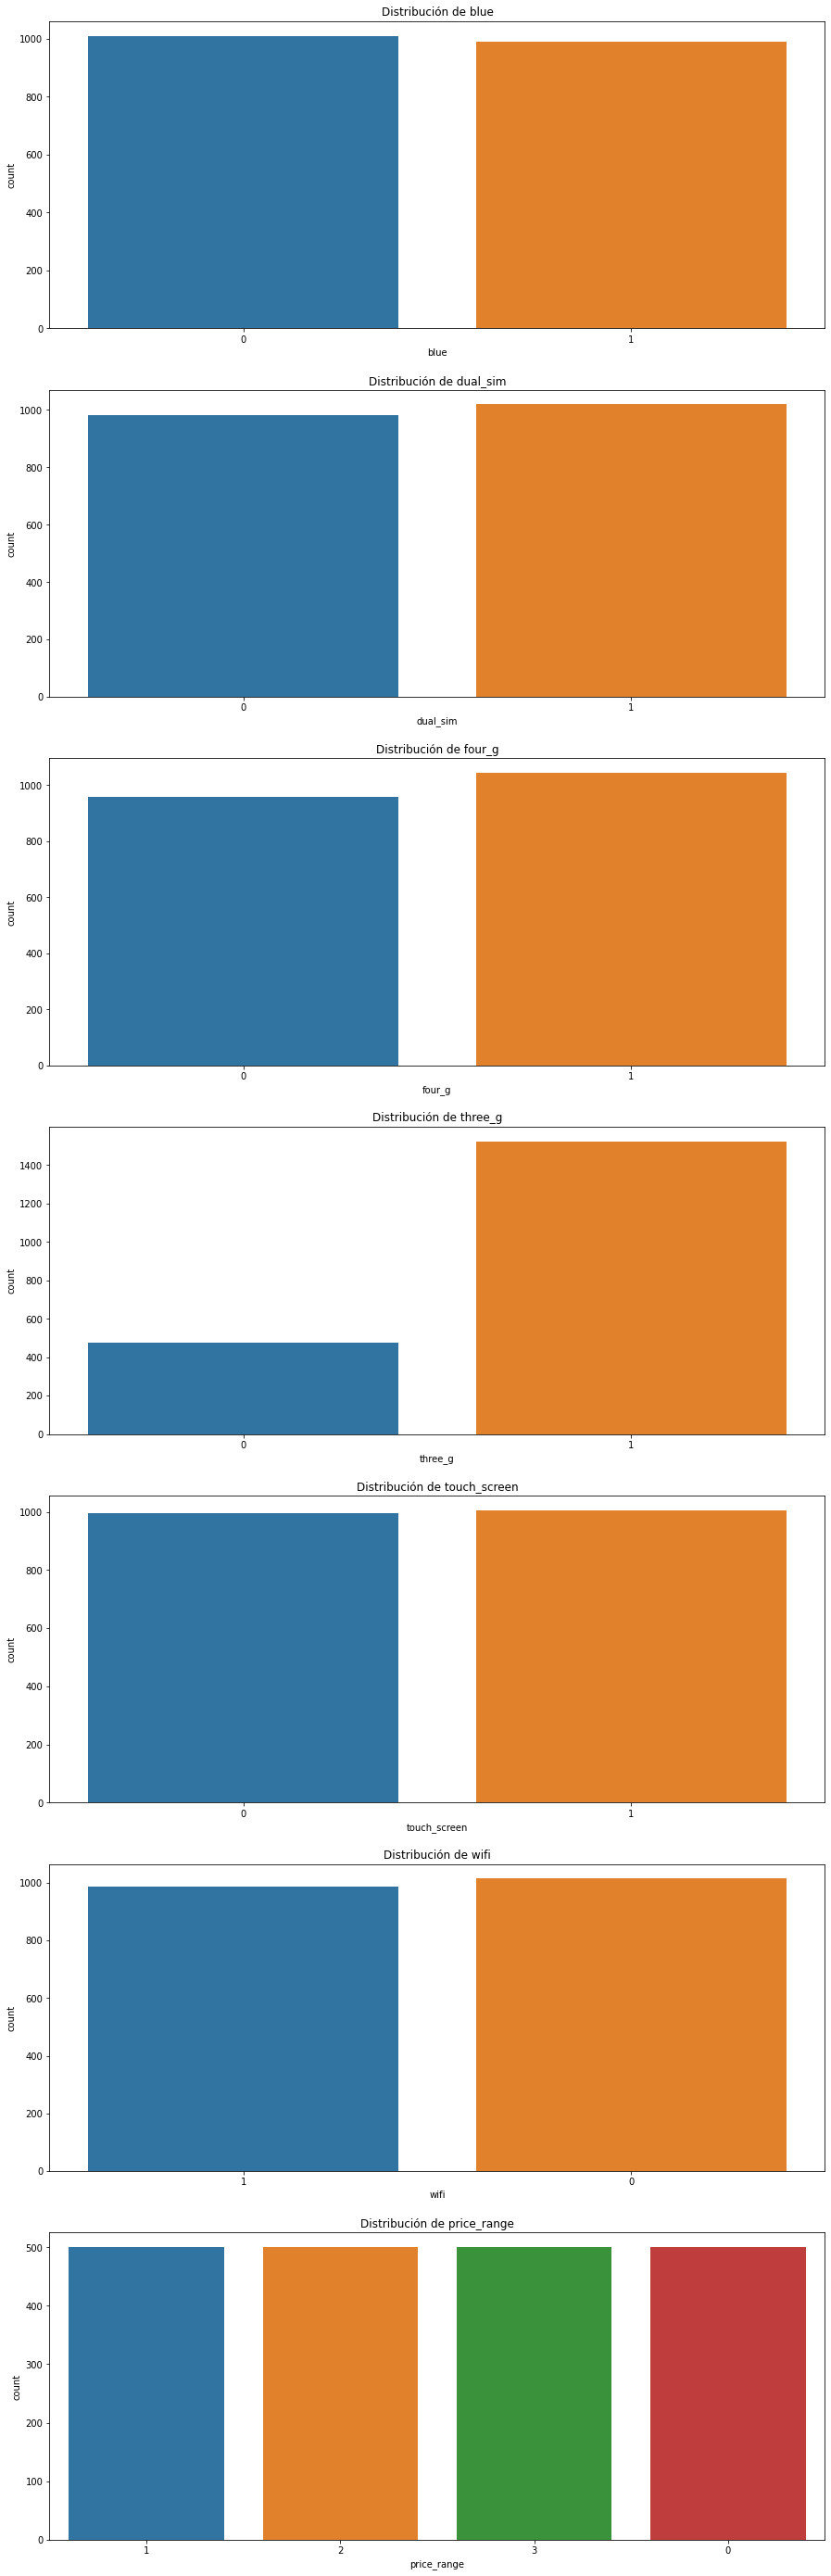

In [10]:
fig, axs = plt.subplots(len(cat_columns), 1, figsize=(15, 50))

count = 0
for column in cat_columns:
    fp = sb.countplot(data[column], ax=axs[count])
    fp.set_title(f'Distribución de {column}')
    fp.set_xticklabels(data[column].unique())
    count += 1

* Se observa que la variable de 3G esta muy descompensada. La mayoría de las muestras petenencen a la categoría 1 (contiene 3G).

* La variable 4G contiene un ligero desbalanceo en el número de las clases, a favor de la clase 1(contiene 4G).

Las demás variables están todas balanceadas.

### Matriz de correlación

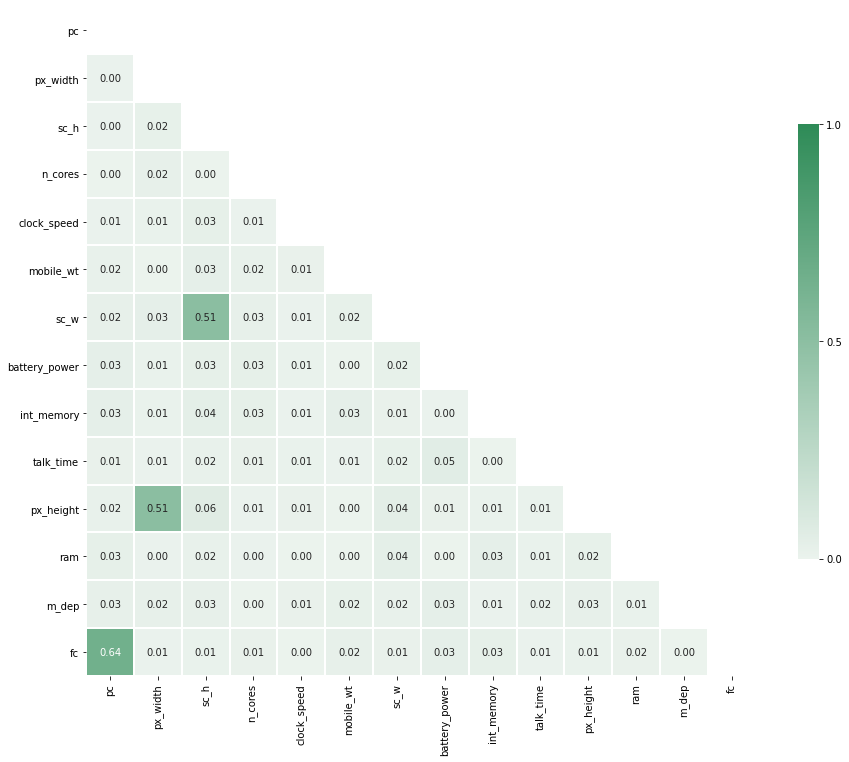

In [11]:
# Calcular correlacion de las variables numericas.
df_matrix_corr = data[num_columns].corr(method='pearson').abs()

# Triangulo inferior de la matrix de correlacion
mask = np.triu(np.ones(df_matrix_corr.shape)).astype(np.bool)

# Grafico de la matriz de correlacion
f, ax = plt.subplots(figsize=(15, 20))
ax.set_yticklabels(df_matrix_corr.columns[1:], rotation=0)
ax.set_xticklabels(df_matrix_corr.columns[:-1], rotation=45)
heatmap = sb.heatmap(
    df_matrix_corr,
    mask=mask,
    square=True,
    linewidths=1,
    cmap=sb.light_palette('seagreen', as_cmap=True),
    cbar_kws={'shrink': .4, 'ticks': [-1, -.5, 0, 0.5, 1]},
    vmin=0,
    vmax=1,
    annot=True,
    annot_kws={"size": 10},
    fmt=".2f"
)

Destacar las siguiente correlaciones:

*  Entre pc y fc: ya que normalmente la camará frontal suele ser la principal del teléfono.

* px_height y px wight: Claramente están relacionadas, pero no lo suficiente como para no tener a las dos encuenta.

* sc_height y sc_wight: Claramente están relacionadas, pero no lo suficiente como para no tener a las dos encuenta.

In [12]:
umbral = 0.75
corr_stack = df_matrix_corr.where(mask).stack().reset_index()
corr_stack.columns = ['Row', 'Column', 'Correlation Value']
corr_75 = corr_stack[(corr_stack['Correlation Value'] > umbral) &
                     (corr_stack['Correlation Value'] < 1)]
corr_75 = corr_75.sort_values(
    by='Correlation Value',
    kind="quicksort",
    ascending=False).drop_duplicates(keep='first')
print(corr_75)

Empty DataFrame
Columns: [Row, Column, Correlation Value]
Index: []


No existe niguna variable con una correlación elevada (superior a 75%), por tanto, se ha considerado no eliminar nigúna variable.

### Tratamiento de missing

In [13]:
percent_null = (data.isnull().sum() / len(data)) * 100
print(percent_null)

battery_power    0.0
blue             0.0
clock_speed      0.0
dual_sim         0.0
fc               0.0
four_g           0.0
int_memory       0.0
m_dep            0.0
mobile_wt        0.0
n_cores          0.0
pc               0.0
px_height        0.0
px_width         0.0
ram              0.0
sc_h             0.0
sc_w             0.0
talk_time        0.0
three_g          0.0
touch_screen     0.0
wifi             0.0
price_range      0.0
dtype: float64


Todas la variables están completas, ninguna presenta muestras faltantes. No se aplica ningún tratamiento de valores faltantes.

## Máquina de Vectores de Soporte

### Pre-procesado

Se separá la variable objetivo de las demás variables.

In [14]:
x = data.drop(columns='price_range')
y = data['price_range']

Separación Hold out. Se utiliza 10% del dataset para test y 90% para entrenamiento y validación, ya que solo se dispone de un dataset con 2000 muestras. Se normalizán los datos y se utiliza one hot enconding en la variable predictoría.

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=42)

# Normalización: Media y desviación.
sc = StandardScaler()
x = sc.fit_transform(x)
print(x)

# One-hot enconding
y = to_categorical(y)
print(y)

print("Datos de entrenamiento:")
print(f"Samples: {x_train.shape}")
print(f"Labels: {y_train.shape}\n")
print("Datos de test:")
print(f"Samples: {x_test.shape}")
print(f"Labels: {y_test.shape}\n")

[[-0.90259726 -0.9900495   0.83077942 ... -1.78686097 -1.00601811
   0.98609664]
 [-0.49513857  1.0100505  -1.2530642  ...  0.55964063  0.99401789
  -1.01409939]
 [-1.5376865   1.0100505  -1.2530642  ...  0.55964063  0.99401789
  -1.01409939]
 ...
 [ 1.53077336 -0.9900495  -0.76274805 ...  0.55964063  0.99401789
  -1.01409939]
 [ 0.62252745 -0.9900495  -0.76274805 ...  0.55964063  0.99401789
   0.98609664]
 [-1.65833069  1.0100505   0.58562134 ...  0.55964063  0.99401789
   0.98609664]]
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]
Datos de entrenamiento:
Samples: (1800, 20)
Labels: (1800,)

Datos de test:
Samples: (200, 20)
Labels: (200,)



## Modelo

Se utiliza cross validation en la fase entrenamiento con 10 folds. Se ajusta el modelo con diferentes hyperparametros y se elige los que mejor resultado nos proporcionan. En este caso, se elige la métrica accuracy para ello.

In [16]:
parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

clf = GridSearchCV(svm.SVC(), parameters, scoring='accuracy', cv=10)
clf.fit(x_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}


In [17]:
svm_model = svm.SVC(kernel=clf.best_params_['kernel'], C=clf.best_params_['C'], random_state=42)
svm_model = svm_model.fit(x_train, y_train)
predicted = svm_model.predict(x_test)
print(predicted)

[0 2 1 3 1 1 2 0 3 1 0 1 2 3 3 2 3 3 1 0 0 2 1 2 0 1 3 3 2 0 0 0 3 0 1 1 2
 0 3 0 2 3 2 0 2 3 2 1 3 1 3 1 0 0 1 1 1 3 0 0 1 3 3 1 0 0 3 3 1 2 2 2 0 1
 2 0 1 3 2 2 3 2 1 0 1 3 1 3 3 0 3 3 2 1 3 2 2 3 1 1 0 0 1 0 0 3 2 0 1 1 0
 0 3 1 3 2 3 2 0 2 1 3 2 1 3 3 0 2 0 2 3 0 2 2 0 3 1 0 0 2 2 1 2 2 0 0 0 1
 1 2 3 1 1 0 2 2 0 1 0 2 2 3 3 3 1 0 1 2 2 3 3 0 1 0 3 1 1 2 1 0 0 0 0 0 3
 2 0 3 0 0 0 0 1 3 3 1 0 1 1 1]


Una vez entrenado y testeado el modelo, se calculán las siguientes métricas de los resultados obtenidos:
* Accuracy 
* Recall
* F1 
* Sensibility
* Specificity

In [18]:
def counts_from_confusion(confusion_matrix):
    count = []

    # Iterate through classes and store the counts
    for i in range(confusion_matrix.shape[0]):
        tp = confusion_matrix[i, i]

        fn_mask = np.zeros(confusion_matrix.shape)
        fn_mask[i, :] = 1
        fn_mask[i, i] = 0
        fn = np.sum(np.multiply(confusion_matrix, fn_mask))

        fp_mask = np.zeros(confusion_matrix.shape)
        fp_mask[:, i] = 1
        fp_mask[i, i] = 0
        fp = np.sum(np.multiply(confusion_matrix, fp_mask))

        tn_mask = 1 - (fn_mask + fp_mask)
        tn_mask[i, i] = 0
        tn = np.sum(np.multiply(confusion_matrix, tn_mask))

        count.append({'Clase': i,
                      'TP': tp,
                      'FN': fn,
                      'FP': fp,
                      'TN': tn})

    tp = (count[0]['TP'] + count[1]['TP'] + count[2]
          ['TP'] + count[3]['TP'])
    tn = (count[0]['TN'] + count[1]['TN'] + count[2]
          ['TN'] + count[3]['TN'])
    fp = (count[0]['FP'] + count[1]['FP'] + count[2]
          ['FP'] + count[3]['FP'])
    fn = (count[0]['FN'] + count[1]['FN'] + count[2]
          ['FN'] + count[3]['FN'])

    return tp, tn, fp, fn, count

Métricas evaluación:
Accuracy: 0.97
Recall: 0.97
F1: 0.97
Specificity: 0.99
Sensibility: 0.97


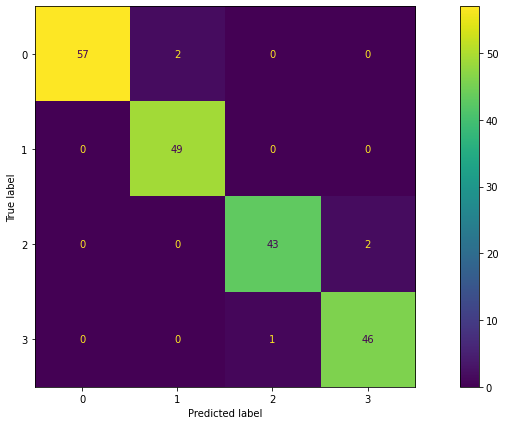

[{'Clase': 0, 'TP': 57, 'FN': 2.0, 'FP': 0.0, 'TN': 141.0}, {'Clase': 1, 'TP': 49, 'FN': 0.0, 'FP': 2.0, 'TN': 149.0}, {'Clase': 2, 'TP': 43, 'FN': 2.0, 'FP': 1.0, 'TN': 154.0}, {'Clase': 3, 'TP': 46, 'FN': 1.0, 'FP': 2.0, 'TN': 151.0}]


In [19]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
tp, tn, fp, fn, dict_confusion = counts_from_confusion(confusion_matrix)

accuracy = metrics.accuracy_score(y_test, predicted)
recall = metrics.recall_score(y_test, predicted, average='micro')
f1 = metrics.f1_score(y_test, predicted, average='micro')
specificity = tn/(tn + fp)
sensibility = tp/(tp + fn)


print("Métricas evaluación:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Sensibility: {sensibility:.2f}")

# Visualizar matriz de confusión
metrics.plot_confusion_matrix(svm_model, x_test, y_test)
plt.show()
print(dict_confusion)

## Redes neuronales

### Pre-procesado

Se separá la variable objetivo de las demás variables.

In [20]:
data = pd.read_csv('/content/datasets_train.csv').to_numpy()
x = data[:, :-1]
y = data[:, -1].astype('int')

# Normalización: Media y desviación.
sc = StandardScaler()
x = sc.fit_transform(x)
print(x)

# One-hot enconding
y = to_categorical(y)
print(y)

[[-0.90259726 -0.9900495   0.83077942 ... -1.78686097 -1.00601811
   0.98609664]
 [-0.49513857  1.0100505  -1.2530642  ...  0.55964063  0.99401789
  -1.01409939]
 [-1.5376865   1.0100505  -1.2530642  ...  0.55964063  0.99401789
  -1.01409939]
 ...
 [ 1.53077336 -0.9900495  -0.76274805 ...  0.55964063  0.99401789
  -1.01409939]
 [ 0.62252745 -0.9900495  -0.76274805 ...  0.55964063  0.99401789
   0.98609664]
 [-1.65833069  1.0100505   0.58562134 ...  0.55964063  0.99401789
   0.98609664]]
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


Separación Hold out. Se utiliza 10% del dataset para test y 90% para entrenamiento y validación, ya se dispone de un dataset con 2000 muestras. Se normalizán los datos y se utilizan one hot enconding en la variable predictoría. Se normalizán los datos y se utiliza one hot enconding en la variable predictoría.

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=42)

print(f"Datos entrenamiento y validacion: {x_train.shape} {y_train.shape}")
print(f"Datos test: {x_test.shape} {y_test.shape}")

Datos entrenamiento y validacion: (1800, 20) (1800, 4)
Datos test: (200, 20) (200, 4)


Se utiliza cross validation en la fase entrenamiento con 10 folds. 
Se utiliza una red neuronal de 4 capas(incluyendo la de entrada). Las 2 capas escondidas son de 32 y 16 neuronas, todas interconectas. Como una función de activación ReLU, que es un estandard. Como capa de salida, se ha utilizado 4 neuronas, una por clase a predecir. Como función de activación, se ha elegido softmax, ya que se trata de un problema de clasificación multiclase. También se ha utilizado la técnica de dropout para evitar que el modelo sobre entrene y intentar que generealize mejor, desconectando de forma aleatoria las conexiones entre neuronas. 

Como algoritmo de optimización se ha utilizado rmsprop:
Es una modificación del algoritmo *Adagrad*. Decrementa la tasa de aprendizaje de forma monótona. Además, en vez de acumular todos los gradientes al cuadrado pasados,  restringe el número acumulado con un tamaño fijo $w$ y realiza un promedio exponencial de todos los gradientes cuadrados pasados $E[g^{2}]_{t}$. Al no tener que acumular todos los gradientes se hace mucho más eficiente. Incorpora $\gamma$ como la fracción igual que se hace en el algoritmo de *momentum*.  Los autores recomiendan utilizar valores de $\gamma=$ 0.9 y $\eta = $ 0.001.

$$E[g^{2}]_{t}=\gamma E[g^{2}]_{t-1} + (1-\gamma )g_{t}^{2}$$ 

$$\theta _{t+1}=\theta _{t}-\frac{\eta }{\sqrt{E[g^{2}]_{t}+\epsilon }}g_{t}$$








Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                672       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 68        
Total params: 1,268
Trainable params: 1,268
Non-trainable params: 0
_________________________________________________________________
----------------------------------------------------------------
Entrenando para el Fold 0
loss of 0.1558920294046402
ac

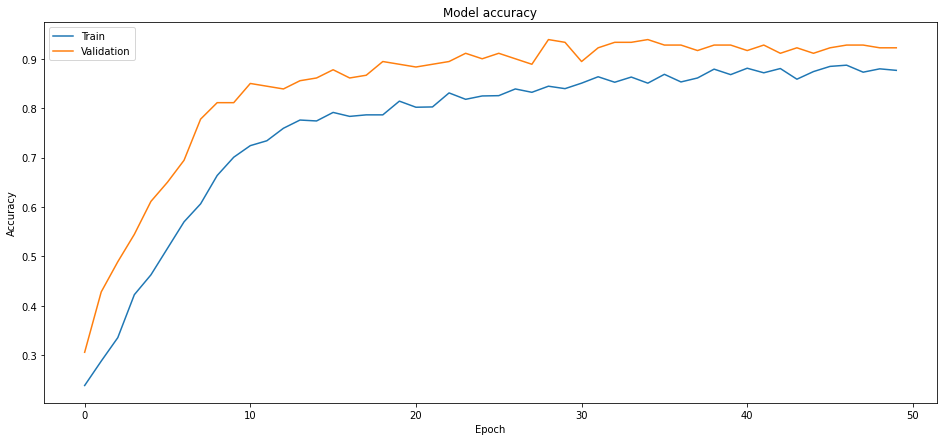

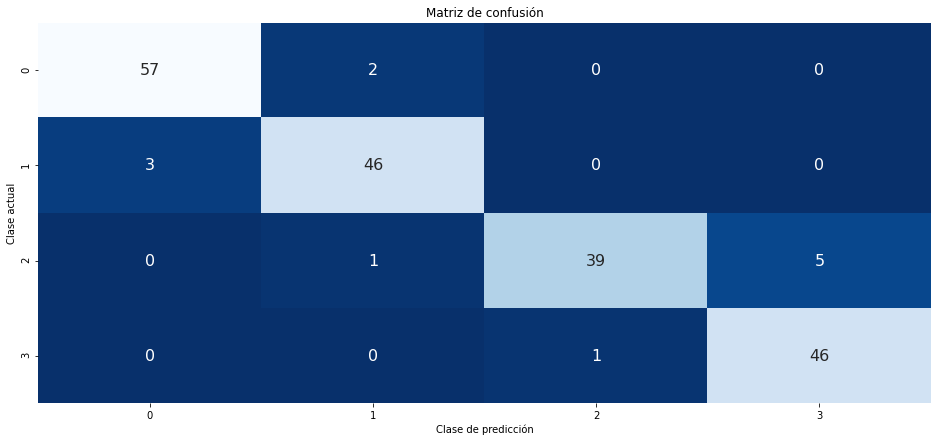

----------------------------------------------------------------
Entrenando para el Fold 1
loss of 0.14731524884700775
accuracy of 93.99999976158142%


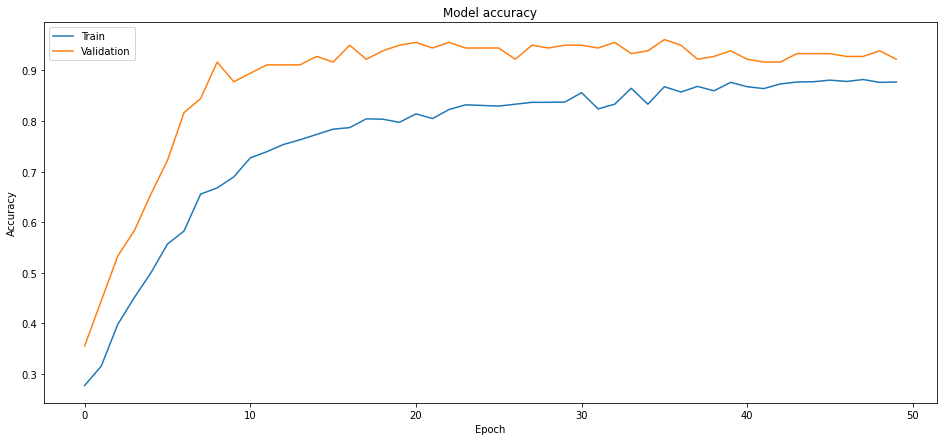

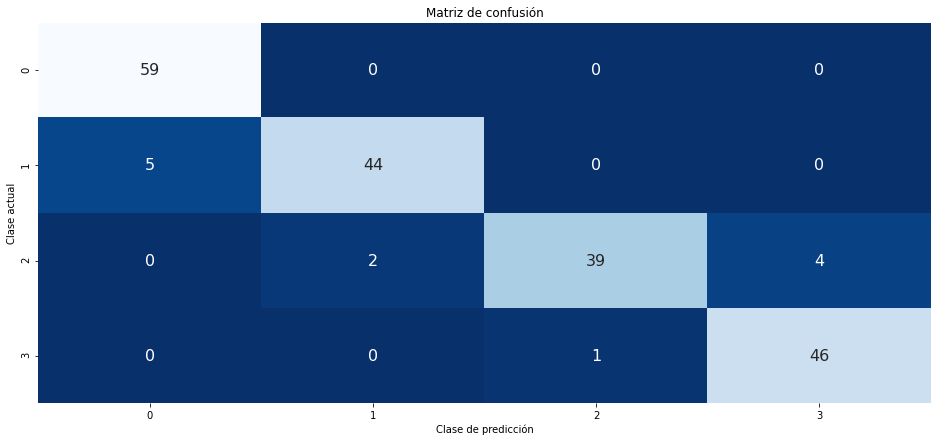

----------------------------------------------------------------
Entrenando para el Fold 2
loss of 0.17902019619941711
accuracy of 93.50000023841858%


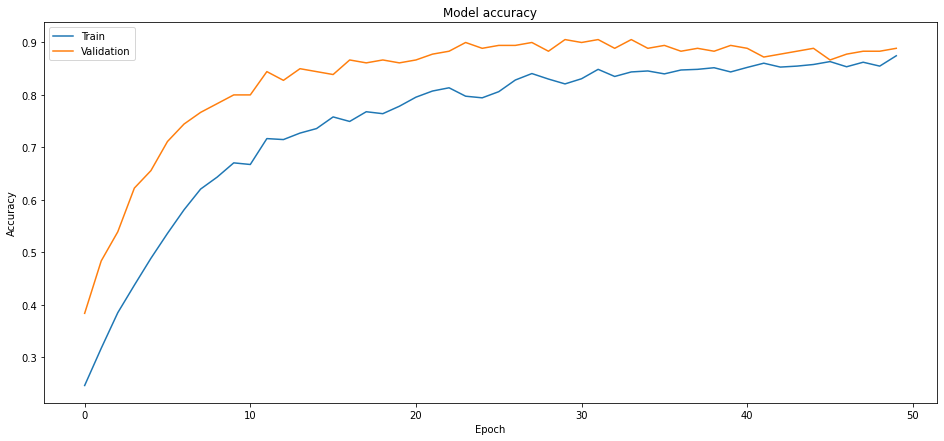

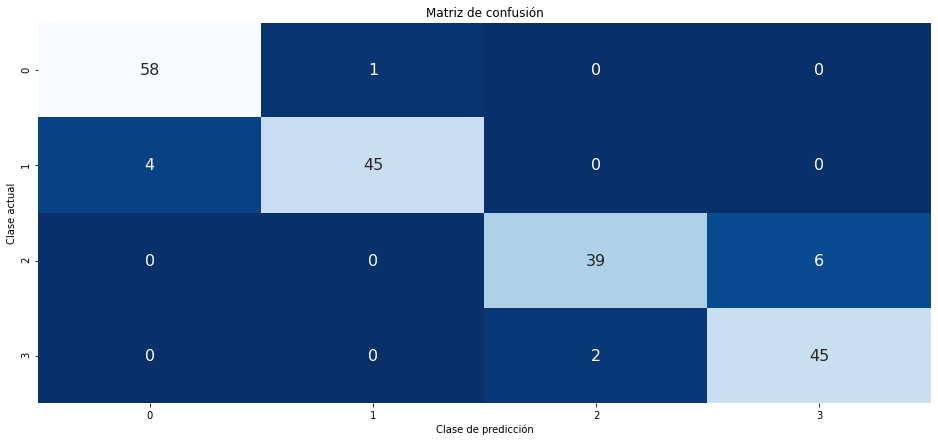

----------------------------------------------------------------
Entrenando para el Fold 3
loss of 0.1743687391281128
accuracy of 93.00000071525574%


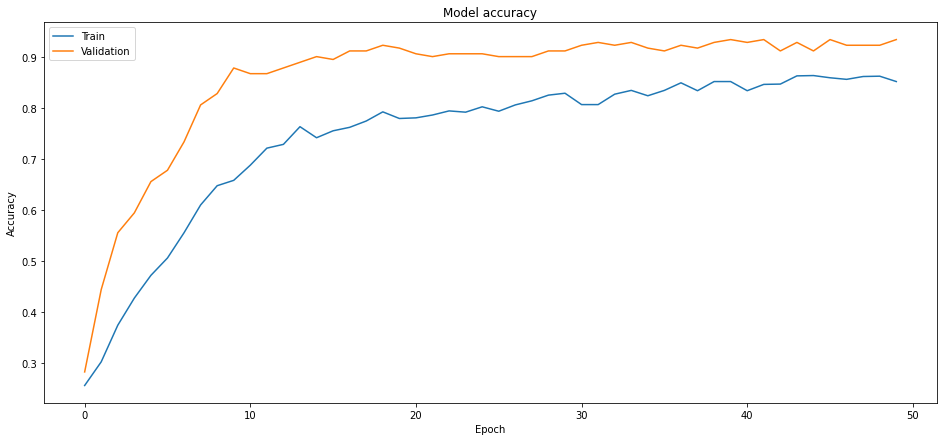

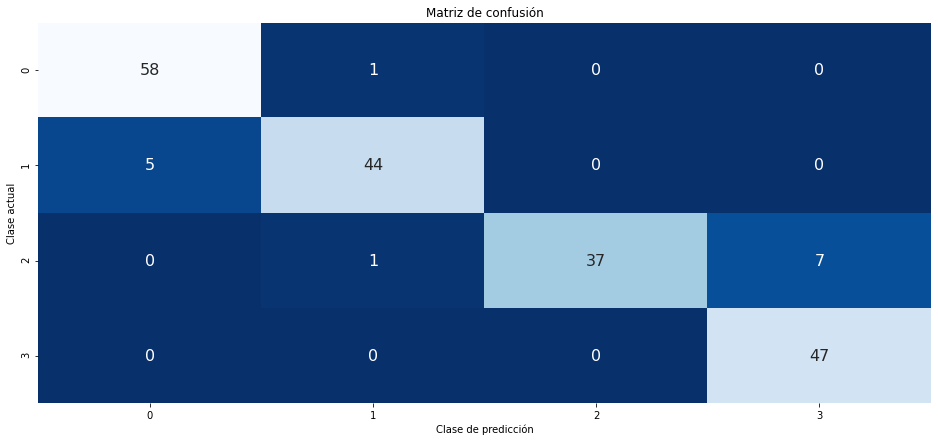

----------------------------------------------------------------
Entrenando para el Fold 4
loss of 0.14039120078086853
accuracy of 93.99999976158142%


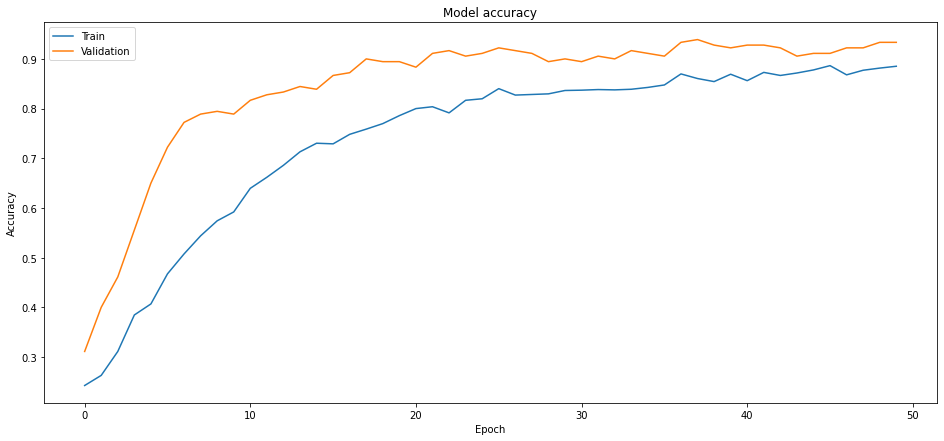

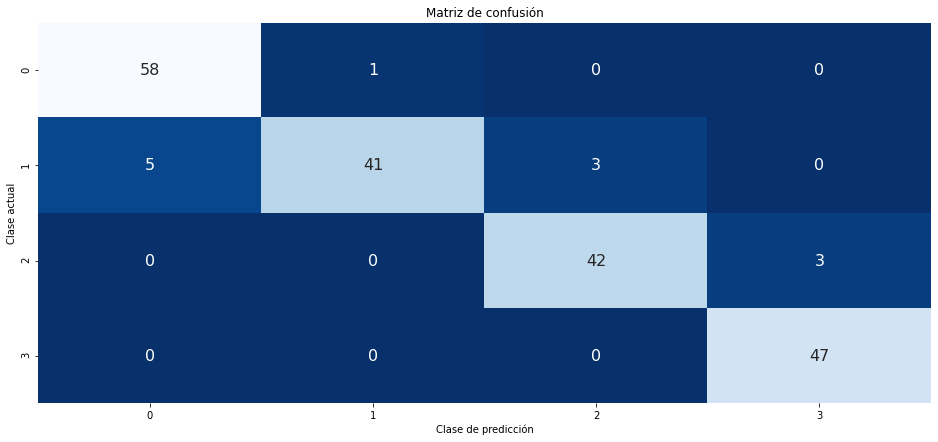

----------------------------------------------------------------
Entrenando para el Fold 5
loss of 0.15488331019878387
accuracy of 92.5000011920929%


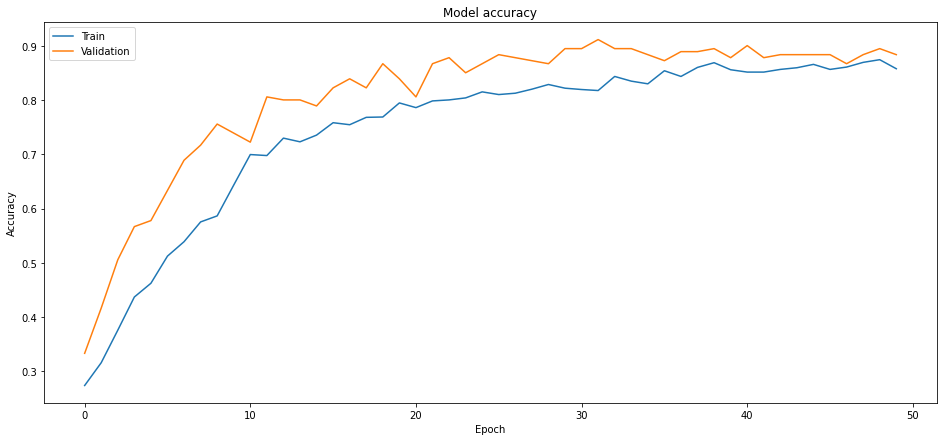

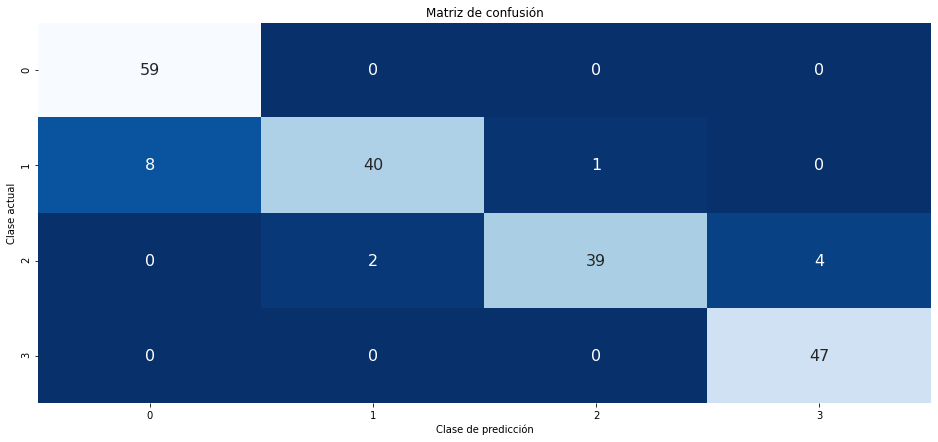

----------------------------------------------------------------
Entrenando para el Fold 6
loss of 0.1500585824251175
accuracy of 95.99999785423279%


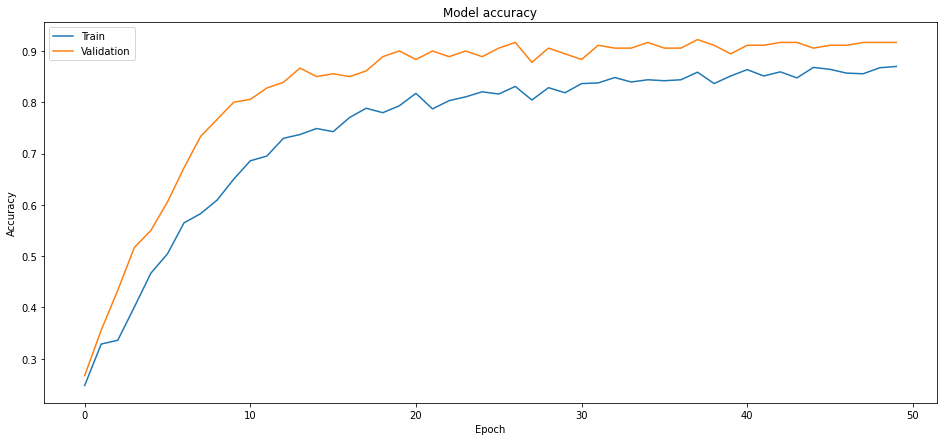

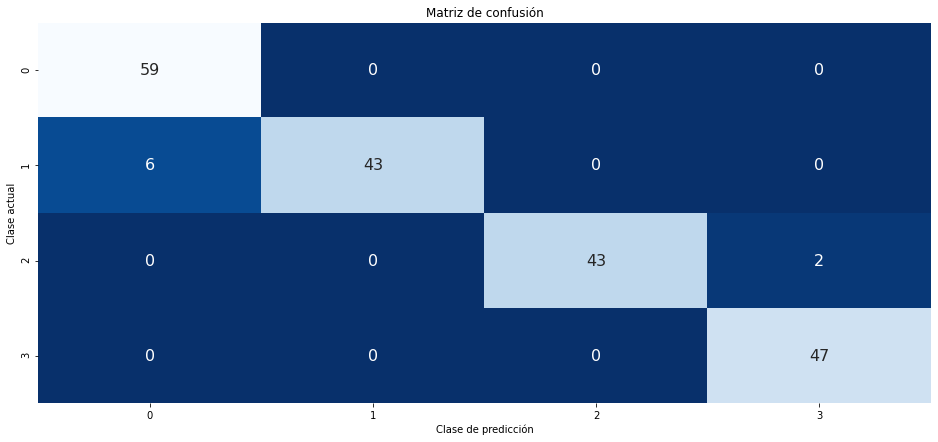

----------------------------------------------------------------
Entrenando para el Fold 7
loss of 0.14798183739185333
accuracy of 94.49999928474426%


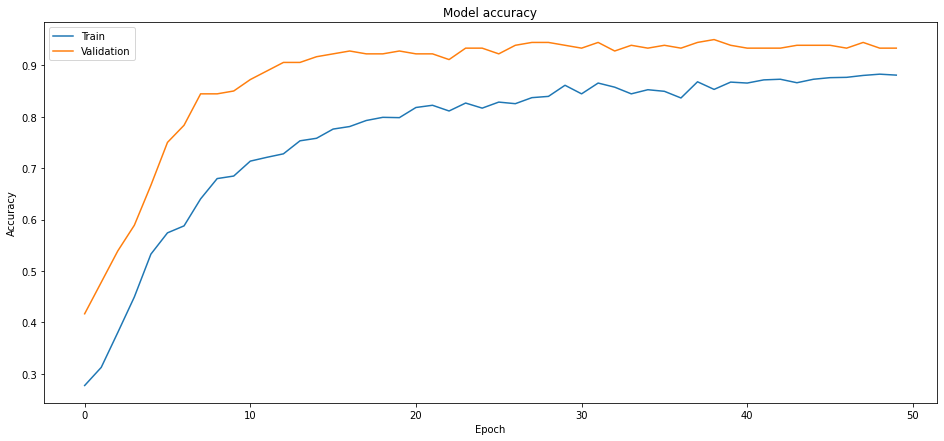

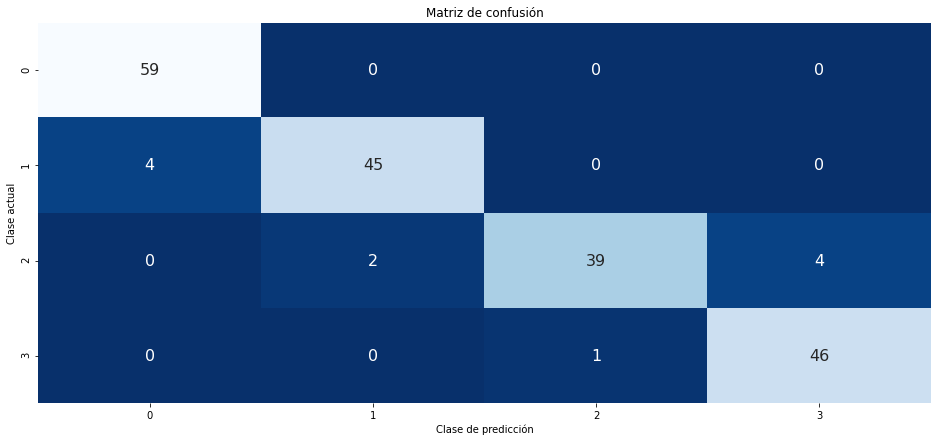

----------------------------------------------------------------
Entrenando para el Fold 8
loss of 0.17089687287807465
accuracy of 93.50000023841858%


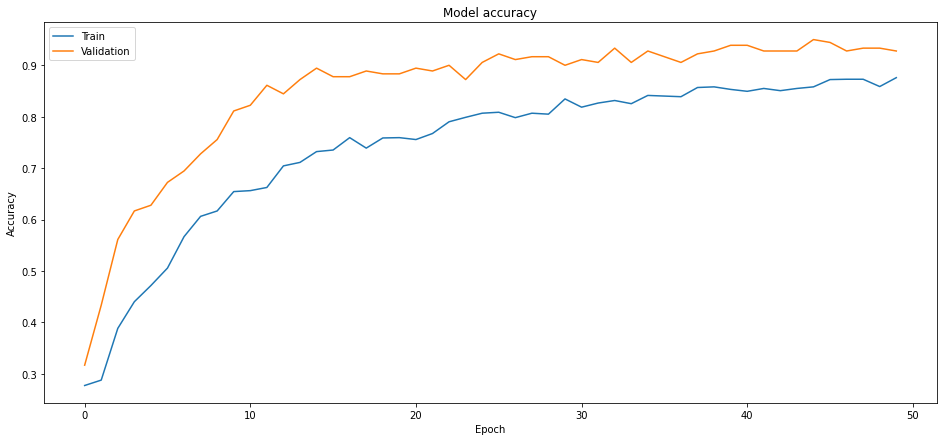

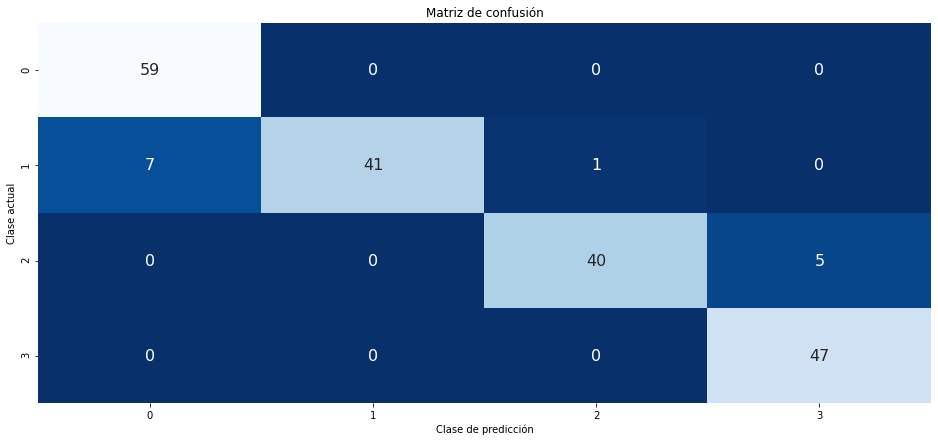

----------------------------------------------------------------
Entrenando para el Fold 9
loss of 0.16179104149341583
accuracy of 93.00000071525574%


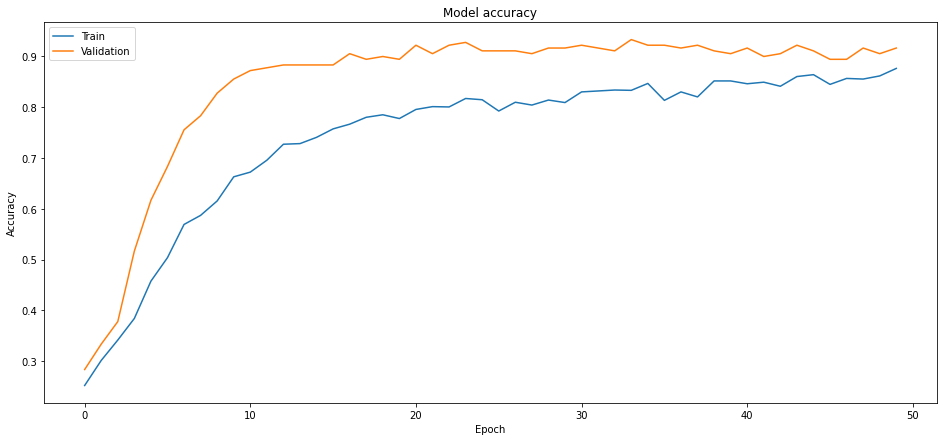

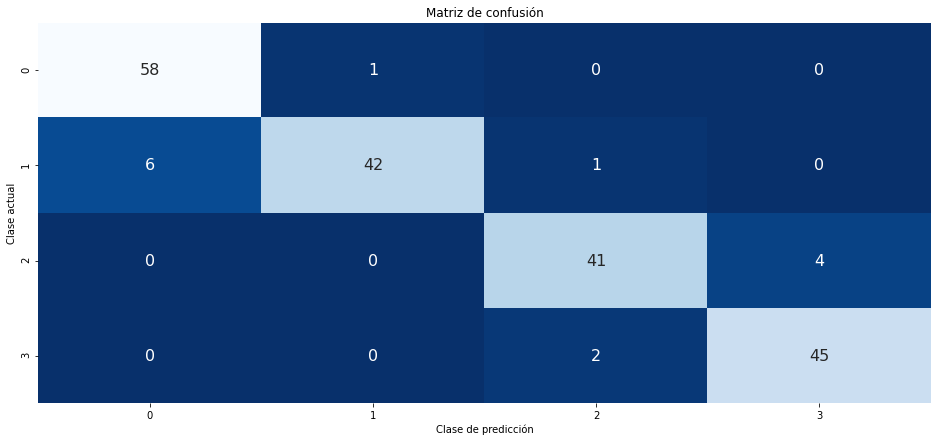


La accuracy media es de 93.79999995231628
La loss media es de 0.15825990587472916


In [22]:
kfold = KFold(n_splits=10, shuffle=True)

fold = 0
accuracy_fold = []
loss_fold = []
for train, validate in kfold.split(x_train, y_train):
    # Datos entrenamiento
    x_train_fold = x_train[train]
    y_train_fold = y_train[train]

    # Datos validacion
    x_valdiate_fold = x_train[validate]
    y_valdiate_fold = y_train[validate]

    # Model
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu', input_shape=(x.shape[1],)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, activation='softmax'))

    model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    # Entrenamiento
    history = model.fit(x_train_fold, y_train_fold,
              validation_data=(x_valdiate_fold, y_valdiate_fold),
              batch_size=16,
              epochs=50,
              verbose=0)

    # Test
    prediction_fold = model.evaluate(x_test, y_test, verbose=0)
    y_predicted = model.predict(x_test)

    if fold == 0:
        model.summary()

    print("----------------------------------------------------------------")
    print(f"Entrenando para el Fold {fold}")
    print(f"{model.metrics_names[0]} of {prediction_fold[0]}")
    print(f"{model.metrics_names[1]} of {prediction_fold[1]*100}%")

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    mc = metrics.confusion_matrix(y_test.argmax(axis=1), 
                                  y_predicted.argmax(axis=1))    
    fig, ax = plt.subplots()
    ax = sb.heatmap(
        mc,
        fmt='.4g',
        annot = True,
        annot_kws={'size': 16},
        cmap= 'Blues_r',
        cbar = False)

    plt.title('Matriz de confusión')
    plt.ylabel('Clase actual')
    plt.xlabel('Clase de predicción')
    plt.ylim(4, 0)
    plt.show()

    accuracy_fold.append(prediction_fold[1] * 100)
    loss_fold.append(prediction_fold[0])

    fold += 1

acc_mean = np.array(accuracy_fold).mean()
loss_mean = np.array(loss_fold).mean()
print(f"\nLa accuracy media es de {acc_mean}")
print(f"La loss media es de {loss_mean}")

Una vez entrenado y testeado el modelo, se calculán las siguientes métricas de los resultados obtenidos:
* Accuracy
* Recall
* F1
* Sensibility
* Specificity

Métricas evaluación:
Accuracy: 0.93
Recall: 0.93
F1: 0.93
Specificity: 0.98
Sensibility: 0.93


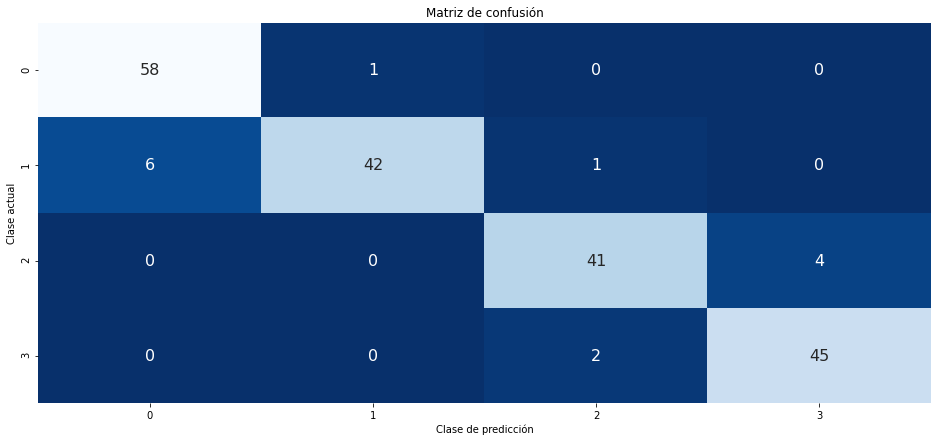

In [23]:
predicted = model.predict(x_test)
confusion_matrix = metrics.confusion_matrix(y_test.argmax(axis=1), 
                                  predicted.argmax(axis=1))
tp, tn, fp, fn, dict_confusion = counts_from_confusion(confusion_matrix)

accuracy = metrics.accuracy_score(y_test.argmax(axis=1), 
                                  predicted.argmax(axis=1))
recall = metrics.recall_score(y_test.argmax(axis=1), 
                                  predicted.argmax(axis=1), average='micro')
f1 = metrics.f1_score(y_test.argmax(axis=1), 
                                  predicted.argmax(axis=1), average='micro')
specificity = tn/(tn + fp)
sensibility = tp/(tp + fn)


print("Métricas evaluación:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"Sensibility: {sensibility:.2f}")


mc = metrics.confusion_matrix(y_test.argmax(axis=1), 
                                  y_predicted.argmax(axis=1))    
fig, ax = plt.subplots()
ax = sb.heatmap(
    mc,
    fmt='.4g',
    annot = True,
    annot_kws={'size': 16},
    cmap= 'Blues_r',
    cbar = False)

plt.title('Matriz de confusión')
plt.ylabel('Clase actual')
plt.xlabel('Clase de predicción')
plt.ylim(4, 0)
plt.show()

# Conclusiones

Las maquinas de vector soporte es el modelo con el que mejor resultados se han obtenido. El mejor kernel ha sido el lineal.

Destacar que las redes neuronal presentan un ligero sobre entrenamiento,incluso después de aplicar la técnica de desconexión de neuronas (Dropout). 
Para mejorar los resultados de las redes neuronales se tendría que aumentar el conjunto de datos, ya que este algoritmo necesita de bastantes datos para poder generalizar al mismo nivel que las maquinas de vector soporte.
También me gustaría añadir que las redes neuronales son más complejas de ajustar, ya que existen más parámetros que con las máquinas de vector soporte. Estoy convencido que utilizando aquitecturas más adecuadas se puede mejorar los resultados.